In [2]:
import os
import datetime
from glob import glob

DOWNLOAD_DIR = '/mimer/NOBACKUP/groups/globalpoverty1/markus/impute_aware_ate/dhs_images/'
NUM_YEAR_SPAN = 1 # How many years before the survey should be used to get median image?
MASK_CLOUDS = True
DROP_FAULTY_L7 = True

def get_file_name_generator(download_dir, num_year_span, mask_clouds, drop_faulty_l7):
    
    num_year_part = str(num_year_span) + '_year'
    mask_clouds_part = 'masked_clouds' if mask_clouds else 'with_clouds'
    drop_l7_part = 'without_slc_error' if drop_faulty_l7 else 'with_slc_error'
    
    file_name = f'landsat_{num_year_part}_median_{mask_clouds_part}_{drop_l7_part}.np'
    
    get_file_name = lambda id: os.path.join(download_dir, id, file_name)
    return get_file_name

get_file_name = get_file_name_generator(DOWNLOAD_DIR, NUM_YEAR_SPAN, MASK_CLOUDS, DROP_FAULTY_L7)

get_file_name('*')

'/mimer/NOBACKUP/groups/globalpoverty1/markus/impute_aware_ate/dhs_images/*/landsat_1_year_median_masked_clouds_without_slc_error.np'

In [5]:
x = get_file_name('*')
files = glob(x)

# get the current date and time
now = datetime.datetime.now()

print(f'{len(files)}, {now}')

29292, 2024-11-22 11:18:03.013116


In [4]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of two cats"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

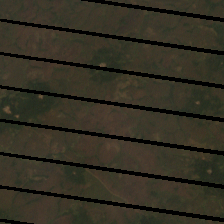

In [7]:
Image.open('/mimer/NOBACKUP/groups/globalpoverty1/markus/impute_aware_ate/dhs_images/GN.Faranah.53.41.png')

Load CSV data

In [1]:
import os
import pandas as pd
import configparser

# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_data.csv'))
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
69944,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
69945,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
69946,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
69947,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


Set up dataloader for dataset

In [2]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RegressionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cluster_id = self.df.iloc[idx]['cluster_id']
        img_name = os.path.join(self.img_dir, cluster_id + '.png')
        image = Image.open(img_name)
        target = (self.df.iloc[idx]['iwi'] / 100)
        if self.transform:
            image = self.transform(image)
        return image, target

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

csv_file = os.path.join(DATA_DIR, 'dhs_data.csv')
img_dir = os.path.join(DATA_DIR, 'dhs_images')

dataset = RegressionDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test iterating through dataset. Takes less than a minute

In [10]:
for images, targets in tqdm(dataloader):
    continue

  3%|▎         | 16/547 [00:10<05:58,  1.48it/s]


KeyboardInterrupt: 

Load pretrained CLIP model and add regression head

In [3]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CLIPRegression(nn.Module):
    def __init__(self, model_name="flax-community/clip-rsicd"):
        super(CLIPRegression, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(model_name)
        self.regression_head = nn.Linear(self.clip_model.config.projection_dim, 1)

    def forward(self, images):
        outputs = self.clip_model.get_image_features(images)
        regression_output = self.regression_head(outputs)
        return regression_output

model = CLIPRegression().to(device)
processor = CLIPProcessor.from_pretrained("flax-community/clip-rsicd")

In [6]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.train()
for epoch in range(10):  # number of epochs
    running_loss = 0.0
    for images, targets in tqdm(dataloader):
        inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)
        pixel_values = inputs['pixel_values']
        
        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = criterion(outputs.squeeze(), targets.to(device).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

  0%|          | 1/547 [00:02<23:58,  2.63s/it]/opt/conda/lib/python3.8/site-packages/transformers/image_transforms.py:396: RuntimeWarning: divide by zero encountered in true_divide
  image = ((image.T - mean) / std).T
/opt/conda/lib/python3.8/site-packages/transformers/image_transforms.py:396: RuntimeWarning: invalid value encountered in true_divide
  image = ((image.T - mean) / std).T
 98%|█████████▊| 538/547 [15:30<00:15,  1.73s/it]


OSError: Caught OSError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/local/tmp.3139224/ipykernel_341275/4171013693.py", line 20, in __getitem__
    image = Image.open(img_name)
  File "/opt/conda/lib/python3.8/site-packages/PIL/Image.py", line 2953, in open
    fp = builtins.open(filename, "rb")
OSError: [Errno 5] Input/output error: '/mimer/NOBACKUP/groups/globalpoverty1/markus/impute_aware_ate/dhs_images/GN.Faranah.53.41.png'


In [11]:
torch.save(model.state_dict(), 'clip_regression.pth')

In [4]:
import torch

# Initialize the model architecture
model = CLIPRegression()

# Load the saved state dictionary
if torch.cuda.is_available():
    device = 'cuda'
    model.load_state_dict(torch.load('clip_regression.pth'))
else:
    device = 'cpu'
    model.load_state_dict(torch.load('clip_regression.pth', map_location=torch.device('cpu')))

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Set the model to evaluation mode
model.eval()

CLIPRegression(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=True)
   

Predict values with finetuned model:

In [17]:
pred_y = []
y = []

with torch.no_grad():
    for images, targets in tqdm(dataloader):
        inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False, do_normalize=False).to(device)
        pixel_values = inputs['pixel_values']

        outputs = model(pixel_values)
        pred_y.append(outputs.flatten())
        y.append(targets.flatten())

100%|██████████| 547/547 [23:57<00:00,  2.63s/it]


In [20]:
pred_y = torch.concat(pred_y)
y = torch.concat(y)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2_score(y.cpu(), pred_y.cpu())

0.508602875121553

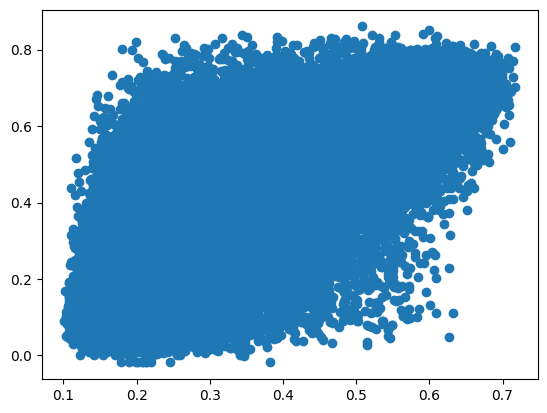

In [25]:
import matplotlib.pyplot as plt

plt.scatter(pred_y.cpu(), y.cpu())